In [152]:
import matplotlib.pyplot as plt
from PIL import Image
import torch.nn as nn
import numpy as np
import os
import json
import torch
from torchvision import models, transforms
from torch.autograd import Variable
import torch.nn.functional as F
from lime import lime_image
from skimage.segmentation import mark_boundaries , quickshift, slic
import requests
import urllib.request
from io import BytesIO
import pickle
import shutil

In [153]:
# Define image paths and names
image_urls = {
    "West_Highland_white_terrier": "https://github.com/EliSchwartz/imagenet-sample-images/raw/master/n02098286_West_Highland_white_terrier.JPEG",
    "American_coot": "https://github.com/EliSchwartz/imagenet-sample-images/raw/master/n02018207_American_coot.JPEG",
    "racer": "https://github.com/EliSchwartz/imagenet-sample-images/raw/master/n04037443_racer.JPEG",
    "flamingo": "https://github.com/EliSchwartz/imagenet-sample-images/raw/master/n02007558_flamingo.JPEG",
    "kite": "https://github.com/EliSchwartz/imagenet-sample-images/raw/master/n01608432_kite.JPEG",
    "goldfish": "https://github.com/EliSchwartz/imagenet-sample-images/raw/master/n01443537_goldfish.JPEG",
    "tiger_shark": "https://github.com/EliSchwartz/imagenet-sample-images/raw/master/n01491361_tiger_shark.JPEG",
    "vulture": "https://github.com/EliSchwartz/imagenet-sample-images/raw/master/n01616318_vulture.JPEG",
    "common_iguana": "https://github.com/EliSchwartz/imagenet-sample-images/raw/master/n01677366_common_iguana.JPEG",
    "orange": "https://github.com/EliSchwartz/imagenet-sample-images/raw/master/n07747607_orange.JPEG"
}

#create images directory
os.makedirs("/kaggle/working/images", exist_ok=True)

# Download images to 'images' folder
for name, url in  image_urls.items():
    response = requests.get(url)
    urllib.request.urlretrieve(url.replace('blob/master/', 'raw/'), f"images/{name}.JPEG")

# Load image function
def get_image(path):
    with open(os.path.abspath(path), 'rb') as f:
        with Image.open(f) as img:
            return img.convert('RGB')

# Transform functions
def get_pil_transform():
    return transforms.Compose([
        #transforms.Pad(16, fill=0, padding_mode='constant'),
        transforms.Resize((256, 256)),
        transforms.CenterCrop(224)
    ])

def get_preprocess_transform():
    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    return transforms.Compose([
        transforms.ToTensor(),
        normalize
    ])    

pill_transf = get_pil_transform()
preprocess_transform = get_preprocess_transform()

In [154]:
# Load model
model = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V2)
model.eval()

# Download and load ImageNet class index with error handling
class_index_path = "/kaggle/working/imagenet-class-index/imagenet_class_index.json"
os.makedirs(os.path.dirname(class_index_path), exist_ok=True)
class_index_url = "https://raw.githubusercontent.com/ndb796/Small-ImageNet-Validation-Dataset-1000-Classes/refs/heads/main/imagenet_class_index.json"
try:
    
    response = requests.get(class_index_url, timeout=10)
    response.raise_for_status()  # Check for HTTP errors
    content = response.text
    # Verify JSON validity
    json.loads(content)  # Test parse
    with open(class_index_path, "w") as f:
        f.write(content)
    with open(class_index_path, 'r') as read_file:
        class_idx = json.load(read_file)
        idx2label = [class_idx[str(k)][1] for k in range(len(class_idx))]
except (requests.RequestException, json.JSONDecodeError) as e:
    print(f"Error downloading or parsing JSON: {e}. Please upload imagenet_class_index.json manually to /kaggle/working/imagenet-class-index/")
    idx2label = []  # Fallback to empty list if JSON fails

# Batch prediction function for LIME
def batch_predict(images):
    model.eval()
    batch = torch.stack(tuple(preprocess_transform(i) for i in images), dim=0)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    batch = batch.to(device)
    logits = model(batch)
    probs = F.softmax(logits, dim=1)
    return probs.detach().cpu().numpy()

Processing: West_Highland_white_terrier
 → LIME


  0%|          | 0/300 [00:00<?, ?it/s]

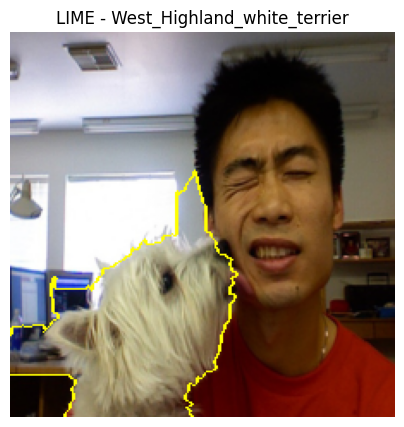

Processing: American_coot
 → LIME


  0%|          | 0/300 [00:00<?, ?it/s]

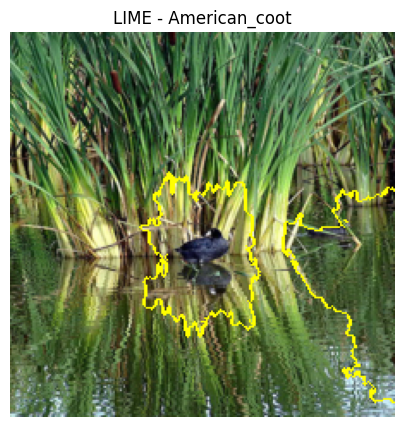

Processing: racer
 → LIME


  0%|          | 0/300 [00:00<?, ?it/s]

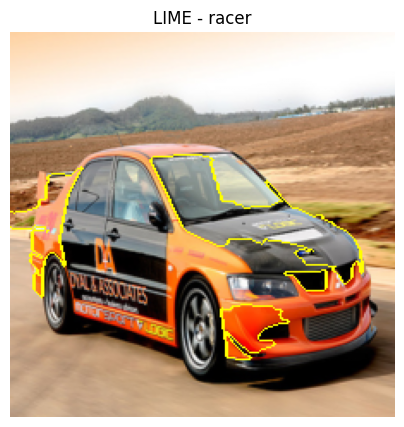

Processing: flamingo
 → LIME


  0%|          | 0/300 [00:00<?, ?it/s]

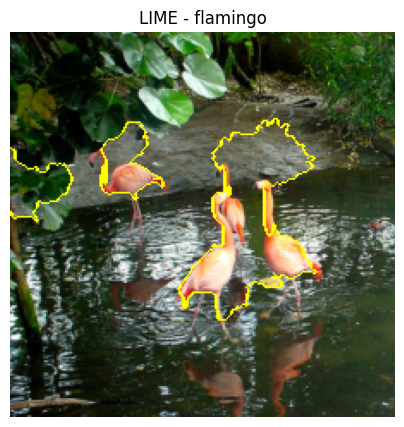

Processing: kite
 → LIME


  0%|          | 0/300 [00:00<?, ?it/s]

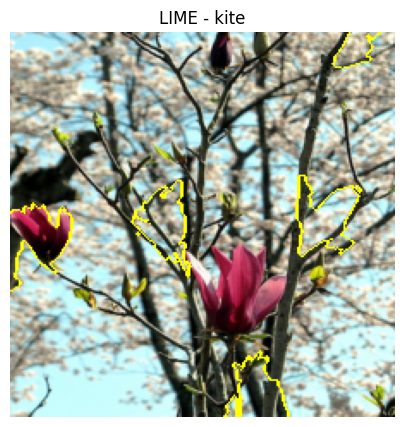

Processing: goldfish
 → LIME


  0%|          | 0/300 [00:00<?, ?it/s]

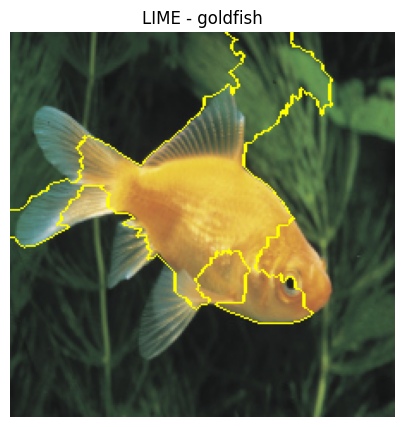

Processing: tiger_shark
 → LIME


  0%|          | 0/300 [00:00<?, ?it/s]

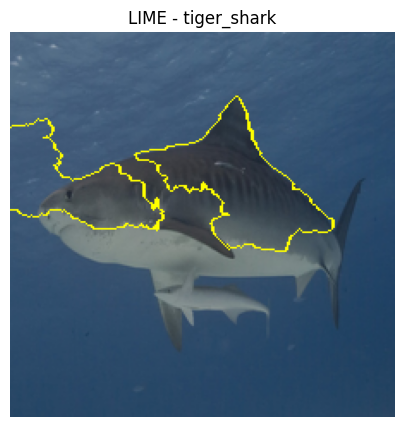

Processing: vulture
 → LIME


  0%|          | 0/300 [00:00<?, ?it/s]

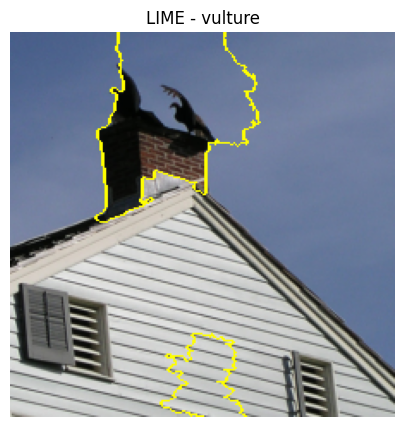

Processing: common_iguana
 → LIME


  0%|          | 0/300 [00:00<?, ?it/s]

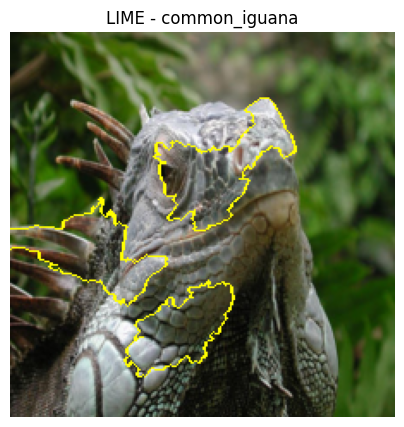

Processing: orange
 → LIME


  0%|          | 0/300 [00:00<?, ?it/s]

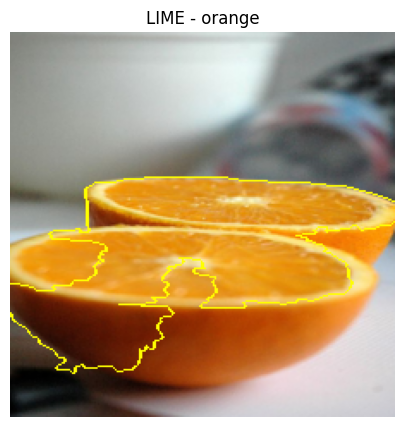

In [337]:
# Process images and generate LIME explanations
explanations = {}
for name, url in image_urls.items():
    print(f"Processing: {name}")

    # Download and open image
    response = requests.get(url.replace('blob/master/', 'raw/'), timeout=10)
    response.raise_for_status()
    img = Image.open(BytesIO(response.content)).convert("RGB")
    img_tensor = preprocess_transform(img).unsqueeze(0)

    # Prepare numpy version for visualization
    img_np = np.array(img.resize((224, 224))) / 255.0

    print(" → LIME")
    
    # Custom segmentation function
    segmentation_fn = segmentation_fn = lambda x: slic(x, n_segments=80, compactness=8, sigma=1)
    
    # Generate LIME explanation with optimized parameters
    explainer = lime_image.LimeImageExplainer()
    explanation = explainer.explain_instance(
        np.array(pill_transf(img)),
        batch_predict,
        top_labels=5,
        hide_color=0,
        num_samples=300,
        num_features=1700,
        batch_size=18,
        distance_metric='cosine',
        #segmentation_fn=segmentation_fn,
        random_seed=42
    )
    temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=False)
    img_boundry = mark_boundaries(temp/255.0, mask)
    
    # Save and show heatmap
    save_path = f"heatmaps/lime/{name}.png"
    os.makedirs(os.path.dirname(save_path), exist_ok=True)
    plt.imsave(save_path, img_boundry)
    
    plt.figure(figsize=(5, 5))
    plt.imshow(img_boundry)
    plt.axis("off")
    plt.title(f"LIME - {name}")
    plt.show()
    
    explanations[name] = explanation

In [336]:
# List containing names of the images to create the dictionary
key_names = ['West_Highland_white_terrier', 'American_coot', 'racer', 'flamingo', 'kite', 'goldfish', 'tiger_shark', 'vulture', 'common_iguana', 'orange']

# Parameters (matching the expected format)
params = {
    "labels": (1,),
    "hide_color": None,
    "top_labels": 5,
    "num_samples": 300,
    "num_features": 1700,
    "batch_size": 18,
    "segmentation_fn": None,
    "distance_metric": "cosine",
    "model_regressor": None,
    "random_seed": None
}

# Create dictionary with parameters for each image
all_params = {}
for i in key_names:
    all_params[i] = params

# # Save the pickle file
with open("/kaggle/working/explain_params.pkl", "wb") as f:
    pickle.dump(all_params, f)

# Submission with your token (replace with your actual token)
token = "50407833"  # Replace with your token
response = requests.post("http://34.122.51.94:9091/lime", files={"file": open("/kaggle/working/explain_params.pkl", "rb")}, headers={"token": token})
print(f"Status: {response.status_code}, Response: {response.text if response.text else 'Empty'}")

Status: 200, Response: {"avg_iou":0.3221205378395001,"avg_time":1.7809785842895507}


In [338]:
 !zip -r heatmaps_report.zip /kaggle/working/heatmaps

updating: kaggle/working/heatmaps/ (stored 0%)
updating: kaggle/working/heatmaps/lime/ (stored 0%)
updating: kaggle/working/heatmaps/lime/flamingo.png (deflated 0%)
updating: kaggle/working/heatmaps/lime/orange.png (deflated 0%)
updating: kaggle/working/heatmaps/lime/goldfish.png (deflated 0%)
updating: kaggle/working/heatmaps/lime/racer.png (deflated 0%)
updating: kaggle/working/heatmaps/lime/kite.png (deflated 0%)
updating: kaggle/working/heatmaps/lime/West_Highland_white_terrier.png (deflated 0%)
updating: kaggle/working/heatmaps/lime/common_iguana.png (deflated 0%)
updating: kaggle/working/heatmaps/lime/American_coot.png (deflated 0%)
updating: kaggle/working/heatmaps/lime/tiger_shark.png (deflated 0%)
updating: kaggle/working/heatmaps/lime/vulture.png (deflated 0%)
